# Market Data Exploration

This notebook demonstrates basic usage of the portfolio optimizer's market data functionality.

In [1]:
# Setup - Add project root to path
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Project imports
from src.data.market_data import MarketDataFetcher, calculate_returns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


## 1. Initialize Market Data Fetcher

In [2]:
fetcher = MarketDataFetcher()
print("Market data fetcher initialized")

Market data fetcher initialized


## 2. Fetch Current Prices

In [3]:
# Define our investment universe
tickers = [
    # Equity ETFs
    "SPY",  # S&P 500
    "QQQ",  # Nasdaq 100
    "IWM",  # Russell 2000
    "VTI",  # Total Stock Market
    "VXUS", # International Stocks
    
    # Bond ETFs
    "TLT",  # 20+ Year Treasury
    "IEF",  # 7-10 Year Treasury
    "AGG",  # Aggregate Bond
    
    # Alternative Assets
    "GLD",  # Gold
    "DBC",  # Commodities
    "VNQ",  # Real Estate
]

# Fetch current prices
current_prices = fetcher.fetch_current_prices(tickers)

# Display as DataFrame
prices_df = pd.DataFrame(list(current_prices.items()), columns=['Ticker', 'Price'])
prices_df = prices_df.sort_values('Ticker')
prices_df

,Ticker,Price
7,AGG,98.5050
9,DBC,22.2750
8,GLD,306.5750
6,IEF,94.7750
2,IWM,222.8850
1,QQQ,556.7200
0,SPY,625.8399
5,TLT,87.1100
10,VNQ,90.1900
3,VTI,308.1800


## 3. Fetch Historical Data

In [4]:
# Fetch 1 year of historical data
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

historical_data = fetcher.fetch_price_history(
    tickers[:5],  # Just first 5 for demo
    start_date=start_date,
    end_date=end_date
)

print(f"Fetched data for {len(historical_data)} tickers")
print(f"Date range: {start_date.date()} to {end_date.date()}")

Fetched data for 5 tickers
Date range: 2024-07-03 to 2025-07-03


## 4. Analyze Returns

In [5]:
# Calculate returns for all tickers
returns_summary = []

for ticker, data in historical_data.items():
    if not data.empty:
        daily_returns = calculate_returns(data, period='daily')
        total_return = calculate_returns(data, period='total')
        
        returns_summary.append({
            'Ticker': ticker,
            'Total Return': total_return,
            'Annualized Return': (1 + total_return) ** (252 / len(daily_returns)) - 1,
            'Daily Volatility': daily_returns.std(),
            'Annual Volatility': daily_returns.std() * np.sqrt(252),
            'Sharpe Ratio': (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))
        })

returns_df = pd.DataFrame(returns_summary)
returns_df = returns_df.round(4)
returns_df

,Ticker,Total Return,Annualized Return,Daily Volatility,Annual Volatility,Sharpe Ratio
0,SPY,0.1490,0.1496,0.0130,0.2056,0.7824
1,QQQ,0.1401,0.1407,0.0161,0.2563,0.6423
2,IWM,0.1169,0.1174,0.0155,0.2460,0.5751
3,VTI,0.1531,0.1538,0.0129,0.2055,0.8006
4,VXUS,0.1691,0.1699,0.0107,0.1691,1.0156


## 5. Visualize Performance

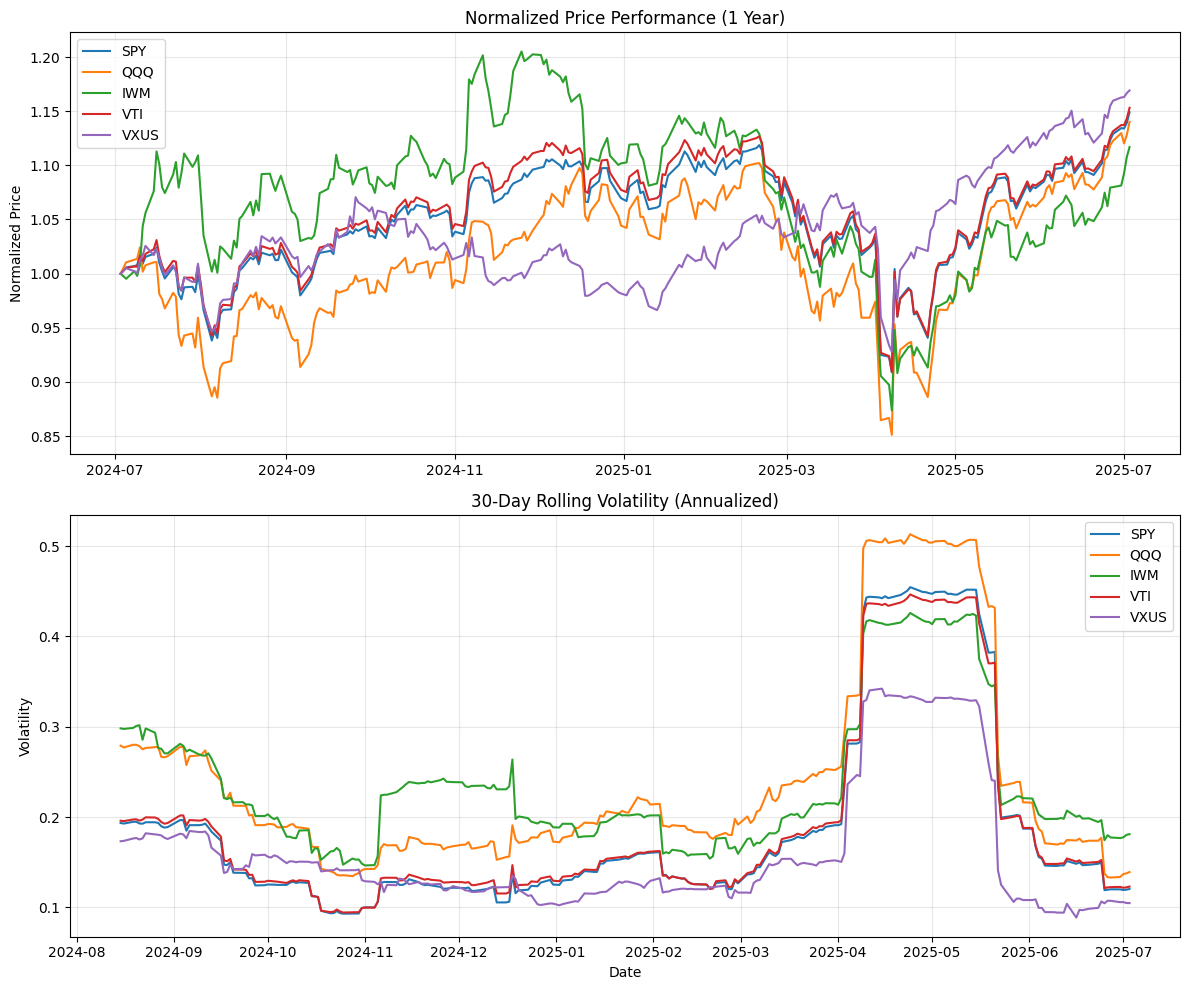

In [6]:
# Create normalized price chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Normalized prices
for ticker, data in historical_data.items():
    if not data.empty:
        normalized_prices = data['Adj Close'] / data['Adj Close'].iloc[0]
        ax1.plot(normalized_prices.index, normalized_prices, label=ticker)

ax1.set_title('Normalized Price Performance (1 Year)')
ax1.set_ylabel('Normalized Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Rolling volatility
for ticker, data in historical_data.items():
    if not data.empty:
        daily_returns = calculate_returns(data, period='daily')
        rolling_vol = daily_returns.rolling(window=30).std() * np.sqrt(252)
        ax2.plot(rolling_vol.index, rolling_vol, label=ticker)

ax2.set_title('30-Day Rolling Volatility (Annualized)')
ax2.set_ylabel('Volatility')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Correlation Analysis

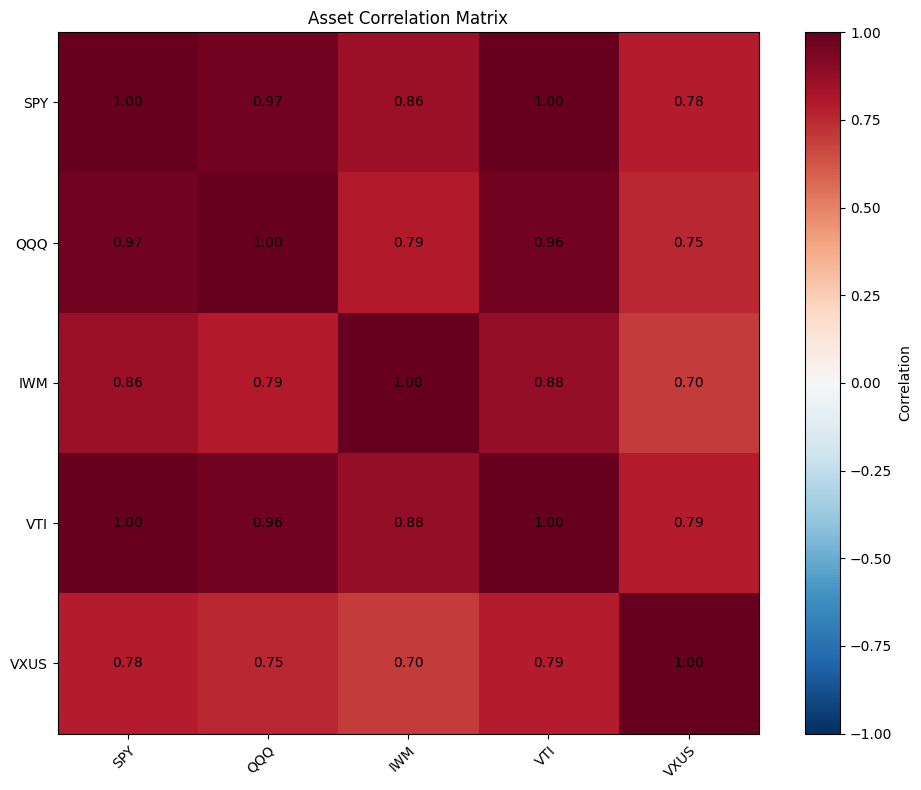

In [7]:
# Calculate correlation matrix
returns_dict = {}

for ticker, data in historical_data.items():
    if not data.empty:
        returns_dict[ticker] = calculate_returns(data, period='daily')

# Create DataFrame of returns
returns_matrix = pd.DataFrame(returns_dict).dropna()

# Calculate correlation
correlation_matrix = returns_matrix.corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)

# Add labels
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.index)))
ax.set_xticklabels(correlation_matrix.columns)
ax.set_yticklabels(correlation_matrix.index)

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation')

# Add correlation values
for i in range(len(correlation_matrix.index)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black")

ax.set_title('Asset Correlation Matrix')
plt.tight_layout()
plt.show()